In [53]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
import cv2 
from numpy import asarray
from PIL import Image, ImageFilter
import glob
%matplotlib inline

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
os.chdir('/content/drive/MyDrive/all_images/all image')
if os.path.isdir('train/normal') is False:
    os.makedirs('train/normal')
    os.makedirs('train/Malignant')
    os.makedirs('valid/normal')
    os.makedirs('valid/Malignant')
    os.makedirs('test/normal')
    os.makedirs('test/Malignant')

    for i in random.sample(glob.glob('Malignant case*'), 448):
        shutil.move(i, 'train/Malignant')      
    for i in random.sample(glob.glob('Normal case*'), 332):
        shutil.move(i, 'train/normal')
    for i in random.sample(glob.glob('Malignant case*'), 56):
        shutil.move(i, 'valid/Malignant')        
    for i in random.sample(glob.glob('Normal case*'), 41):
        shutil.move(i, 'valid/normal')
    for i in random.sample(glob.glob('Malignant case*'), 56):
        shutil.move(i, 'test/Malignant')      
    for i in random.sample(glob.glob('Normal case*'), 41):
        shutil.move(i, 'test/normal')


In [56]:
train_path = '/content/drive/MyDrive/all_images/all image/train'
valid_path = '/content/drive/MyDrive/all_images/all image/valid'
test_path = '/content/drive/MyDrive/all_images/all image/test'

In [57]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 780 images belonging to 2 classes.
Found 97 images belonging to 2 classes.
Found 97 images belonging to 2 classes.


In [58]:
def preprocessingfunction(train_batches):

    imgs, labels = next(train_batches)
    imgs=imgs.astype(np.uint8)
    data = [] 

    for i in range(10): 
        img=imgs[i]
        #print(i)
        img = cv2.resize(img, (224, 224))
        #remove noise
        img = cv2.GaussianBlur(img,(5,5),0)
   
    
        array = asarray(img)
        #see edges 
        img=Image.fromarray((array))
        final= img.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, -1, 8,-1, -1, -1, -1), 1, 0))
        img=final+array  
        img=Image.fromarray((img))
        #img = img.filter(ImageFilter.FIND_EDGES)
        # Convert the image to grayscale
        img = img.convert("L")
        img = asarray(img)
        #segmnation
        ret, img = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
        #d, img = hog(img, orientations=9 ,pixels_per_cell=(4, 4)
        #                ,cells_per_block=(2, 2), visualize=True)# multichannel=True
        #img = exposure.rescale_intensity(img, in_range=(0, 10)) 
 
        #append in=mage in data
        data.append(img)
    train_batches=data, labels
    print(train_batches)

In [59]:
preprocessingfunction(train_batches)

([array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 

In [60]:
def preprocessingfunction_v(valid_batches):

    imgs, labels = next(valid_batches)
    imgs=imgs.astype(np.uint8)
    data = [] 

    for i in range(10): 
        img=imgs[i]
        #print(i)
        img = cv2.resize(img, (224, 224))
        #remove noise
        img = cv2.GaussianBlur(img,(5,5),0)
   
    
        array = asarray(img)
        #see edges 
        img=Image.fromarray((array))
        final= img.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, -1, 8,-1, -1, -1, -1), 1, 0))
        img=final+array  
        img=Image.fromarray((img))
        #img = img.filter(ImageFilter.FIND_EDGES)
        # Convert the image to grayscale
        img = img.convert("L")
        img = asarray(img)
        #segmnation
        ret, img = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
        #d, img = hog(img, orientations=9 ,pixels_per_cell=(4, 4)
        #                ,cells_per_block=(2, 2), visualize=True)# multichannel=True
        #img = exposure.rescale_intensity(img, in_range=(0, 10)) 
 
        #append in=mage in data
        data.append(img)
        #عشان متكومش label بتتعاد
    valid_batches=imgs, labels
    print(valid_batches)

In [61]:
#preprocessingfunction_v(valid_batches)

In [62]:
print(train_batches)

In [63]:
imgs, labels = next(train_batches)

In [64]:
#imgs=imgs.astype(np.uint8)

In [65]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [66]:
arr=preprocessingfunction(train_batches)
print(arr)

([array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

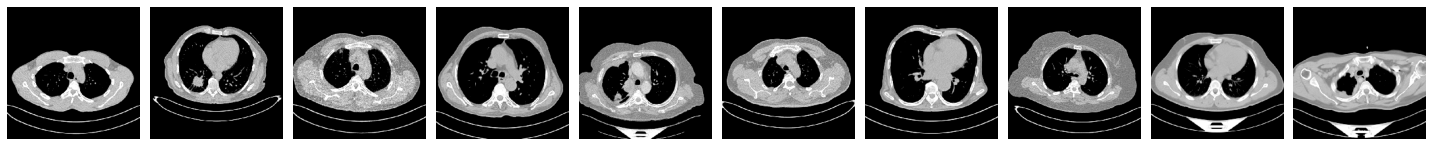

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [67]:
plotImages(imgs)
print(labels)

In [68]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [69]:
x = mobile.layers[-1].output
x

<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'predictions')>

In [70]:
output = Dense(units=2, activation='softmax')(x)
output

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_6')>

In [71]:
model = Model(inputs=mobile.input, outputs=output)
model

In [72]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [73]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [74]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [75]:
train_batches

In [76]:
valid_batches

In [77]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=30,
            verbose=2
)


Epoch 1/30
78/78 - 72s - loss: 0.6729 - accuracy: 0.9090 - val_loss: 0.6939 - val_accuracy: 0.4845 - 72s/epoch - 920ms/step
Epoch 2/30
78/78 - 59s - loss: 0.6585 - accuracy: 0.9833 - val_loss: 0.6786 - val_accuracy: 0.7113 - 59s/epoch - 754ms/step
Epoch 3/30
78/78 - 61s - loss: 0.6525 - accuracy: 0.9846 - val_loss: 0.6561 - val_accuracy: 0.9485 - 61s/epoch - 781ms/step
Epoch 4/30
78/78 - 56s - loss: 0.6461 - accuracy: 0.9949 - val_loss: 0.6532 - val_accuracy: 0.9175 - 56s/epoch - 716ms/step
Epoch 5/30
78/78 - 55s - loss: 0.6423 - accuracy: 0.9782 - val_loss: 0.6505 - val_accuracy: 0.8969 - 55s/epoch - 708ms/step
Epoch 6/30
78/78 - 56s - loss: 0.6360 - accuracy: 0.9923 - val_loss: 0.6341 - val_accuracy: 1.0000 - 56s/epoch - 722ms/step
Epoch 7/30
78/78 - 56s - loss: 0.6310 - accuracy: 0.9910 - val_loss: 0.6292 - val_accuracy: 0.9897 - 56s/epoch - 719ms/step
Epoch 8/30
78/78 - 55s - loss: 0.6262 - accuracy: 0.9962 - val_loss: 0.6234 - val_accuracy: 1.0000 - 55s/epoch - 706ms/step
Epoch 9/

In [78]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [79]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [80]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm

array([[56,  0],
       [ 0, 41]])